In [3]:
############################### MODEL 1 ############################### 

from dataset.utils import pNormalize, classCount
from dataset.datasets import sentinel
from model.models import UNET
from torch.utils.data import DataLoader
from train.metrics import computeConfMats, computeClassMetrics, wma, printClassMetrics, printModelMetrics, plotConfusionMatrices, plotConfusionMatrix
import torch

q_hi = torch.tensor([2102.0, 1716.0, 1398.0, 4732.0, 2434.42919921875, 3701.759765625, 4519.2177734375, 4857.7734375, 3799.80322265625, 3008.8935546875])
q_lo = torch.tensor([102.0, 159.0, 107.0, 77.0, 106.98081970214844, 79.00384521484375, 86.18966674804688, 70.40167236328125, 50.571197509765625, 36.95356750488281])    
norm = pNormalize(maxPer=q_hi,minPer=q_lo)

# Hyperparams
BATCH_SIZE = 4
NUM_WORKERS = 0

# Create experimental dataset, rgb=True for 3 channels (default = False)
# POINT TO FOLDER WITH TIMEPERIOD(S) WITH SUBFOLDERS: 'test, 'train, 'val
val_set = sentinel(root_dir='./dataset', img_transform=norm,data="val")

# Pass in the dataset into DataLoader to create an iterable over the dataset
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Define model
dataiter = iter(val_loader)
images, labels = dataiter.next()
model_1 = UNET(in_channels=images.shape[1],classes=28)
model_1.load_state_dict(torch.load('model_epoch_89.pt',map_location=torch.device('cpu'))) # Pass in 'trained_model.pt' and load model

# 1 EPOCH TESTING
dataiter = iter(val_loader) # Create an object which can be iterated one element at a time
model_1.eval() # TOGGLE ON EVALUATION MODE
with torch.no_grad():
     cMats_1 = torch.zeros((27,2,2),dtype=torch.int32) # n_class - unclassified class, i.e. 28-1 = 27
     
     for images, labels in dataiter:
          outputs = model_1(images)
          preds = torch.nn.functional.softmax(outputs,dim=1)
          preds = torch.argmax(preds,dim=1)
          cMats_1 += computeConfMats(labels,preds)      

#model_1.train() # TOGGLE ON TRAIN MODE WHEN EVALUATION IS DONE

In [4]:
# Get class counts for dataset
classCounts,_ = classCount(val_loader)

In [5]:
# Compute class IoU for model 1
iou_1 = computeClassMetrics(cMats_1)[:,4]

In [6]:
############################### MODEL 2 ############################### 

q_hi = torch.tensor([2102.0, 1716.0, 1398.0, 4732.0, 2434.42919921875, 3701.759765625, 4519.2177734375, 4857.7734375, 3799.80322265625, 3008.8935546875])
q_lo = torch.tensor([102.0, 159.0, 107.0, 77.0, 106.98081970214844, 79.00384521484375, 86.18966674804688, 70.40167236328125, 50.571197509765625, 36.95356750488281])    
norm = pNormalize(maxPer=q_hi,minPer=q_lo)

# Hyperparams
BATCH_SIZE = 4
NUM_WORKERS = 0

# Create experimental dataset, rgb=True for 3 channels (default = False)
# POINT TO FOLDER WITH TIMEPERIOD(S) WITH SUBFOLDERS: 'test, 'train, 'val
val_set = sentinel(root_dir='./dataset', img_transform=norm,data="val")

# Pass in the dataset into DataLoader to create an iterable over the dataset
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Define model
dataiter = iter(val_loader)
images, labels = dataiter.next()
model_2 = UNET(in_channels=images.shape[1],classes=28)
model_2.load_state_dict(torch.load('model_epoch_67.pt',map_location=torch.device('cpu'))) # Pass in 'trained_model.pt' and load model

# 1 EPOCH TESTING
dataiter = iter(val_loader) # Create an object which can be iterated one element at a time
model_2.eval() # TOGGLE ON EVALUATION MODE
with torch.no_grad():
     cMats_2 = torch.zeros((27,2,2),dtype=torch.int32) # n_class - unclassified class, i.e. 28-1 = 27
         
     for images, labels in dataiter:
          outputs = model_2(images)
          preds = torch.nn.functional.softmax(outputs,dim=1)
          preds = torch.argmax(preds,dim=1)
          cMats_2 += computeConfMats(labels,preds)

#model_2.train() # TOGGLE ON TRAIN MODE WHEN EVALUATION IS DONE

In [7]:
# Compute class IoU for model 2
iou_2 = computeClassMetrics(cMats_2)[:,4]

In [8]:
# Compute late fusion weights (performance weighting)
iou_sum = iou_1 + iou_2

for i in (range(len(iou_sum))):
    if iou_sum[i] != 0:
        iou_sum[i] = 1/iou_sum[i]

lf_weights_1 = torch.multiply(iou_1, iou_sum)
lf_weights_2 = torch.multiply(iou_2, iou_sum)

# NB! Label 0 is uniformly-weighted (not performance weighted)
s = torch.tensor([0.5])

lf_weights_1 = torch.cat((s,lf_weights_1),dim=0)
lf_weights_2 = torch.cat((s,lf_weights_2),dim=0)

In [9]:
############################### Late Fusion: Model 1 & Model 2 using Weighted Sum Rule ############################### 

# 1 EPOCH TESTING
dataiter = iter(val_loader) # Create an object which can be iterated one element at a time
model_1.eval() # TOGGLE ON EVALUATION MODE
model_2.eval() # TOGGLE ON EVALUATION MODE
with torch.no_grad():         
     cMats_lf = torch.zeros((27,2,2),dtype=torch.int32) # n_class - unclassified class, i.e. 28-1 = 27
         
     predarr = torch.tensor([],dtype=torch.int32)
     labelarr = torch.tensor([],dtype=torch.int32)
     
     for images, labels in dataiter:
          outputs_1 = model_1(images)
          outputs_2 = model_2(images)
          
          softmaxOutput_1 = torch.nn.functional.softmax(outputs_1,dim=1)
          softmaxOutput_2 = torch.nn.functional.softmax(outputs_2,dim=1)
          
          for i in range(len(iou_sum)):
               softmaxOutput_1[:,i,:,:] = torch.multiply(softmaxOutput_1[:,i,:,:],lf_weights_1[i])
               softmaxOutput_2[:,i,:,:] = torch.multiply(softmaxOutput_2[:,i,:,:],lf_weights_2[i])
          
          softmaxWeightedSum = torch.add(softmaxOutput_1,softmaxOutput_2)
              
          preds = torch.argmax(softmaxWeightedSum,dim=1)
          
          cMats_lf += computeConfMats(labels,preds)
          
          # Flatten dimensions BxHxW --> B*H*W and concatenate
          predarr = torch.cat((predarr, preds.reshape(-1)))
          labelarr = torch.cat((labelarr, labels.reshape(-1)))
#model_1.train() # TOGGLE ON TRAIN MODE WHEN EVALUATION IS DONE
#model_2.train()

In [10]:
# Compute class and model metrics for late fusion model
class_metrics_lf = computeClassMetrics(cMats_lf)
model_metrics_lf = wma(class_metrics_lf,classCounts)

In [11]:
# Print model metrics for late fusion model
printModelMetrics(model_metrics_lf)

@@ Weighted Macro-Average Model Metrics @@

Accuracy                           : 0.9260
Precision                          : 0.7728
Recall                             : 0.7307
F1-Score                           : 0.7435
Intersection over Union            : 0.6221
Matthews Correlation Coefficient   : 0.6957


In [12]:
# Print class metrics for late fusion model
printClassMetrics(class_metrics_lf,classCounts)

@@ Class Metrics @@

Label    UA2018 ID       % Data     Accuracy   Precision  Recall     F1-Score   IoU        MCC        Description
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1        11100           0.04       0.9996     0.4596     0.7412     0.5674     0.3961     0.5835     Continuous Urban Fabric
2        11210           0.32       0.9954     0.3889     0.7354     0.5088     0.3412     0.5328     Discontinuous Dense Urban Fabric
3        11220           0.84       0.9873     0.3575     0.6362     0.4578     0.2969     0.4712     Discontinuous Medium Density Urban Fabric
4        11230           2.49       0.9731     0.4627     0.5178     0.4887     0.3233     0.4757     Discontinuous Low Density Urban Fabric
5        11240           2.75       0.9691     0.4559     0.6353     0.5309     0.3613     0.5229     Discontinuous Very Low Density U

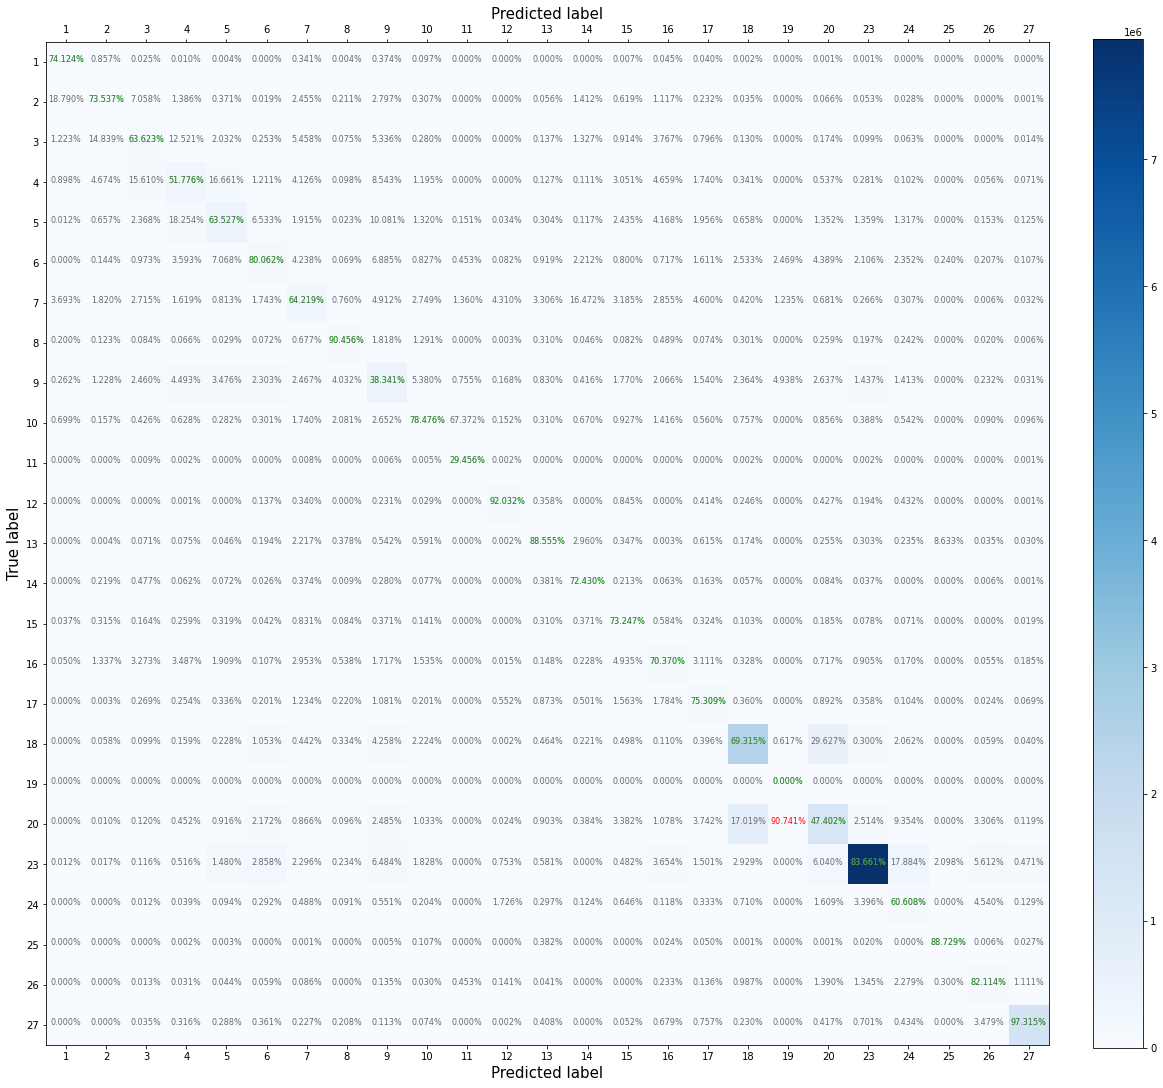

In [13]:
# Plot N_CLASS X N_CLASS confusion matrix for late fusion model
plotConfusionMatrix(yTrue=labelarr,yPred=predarr)

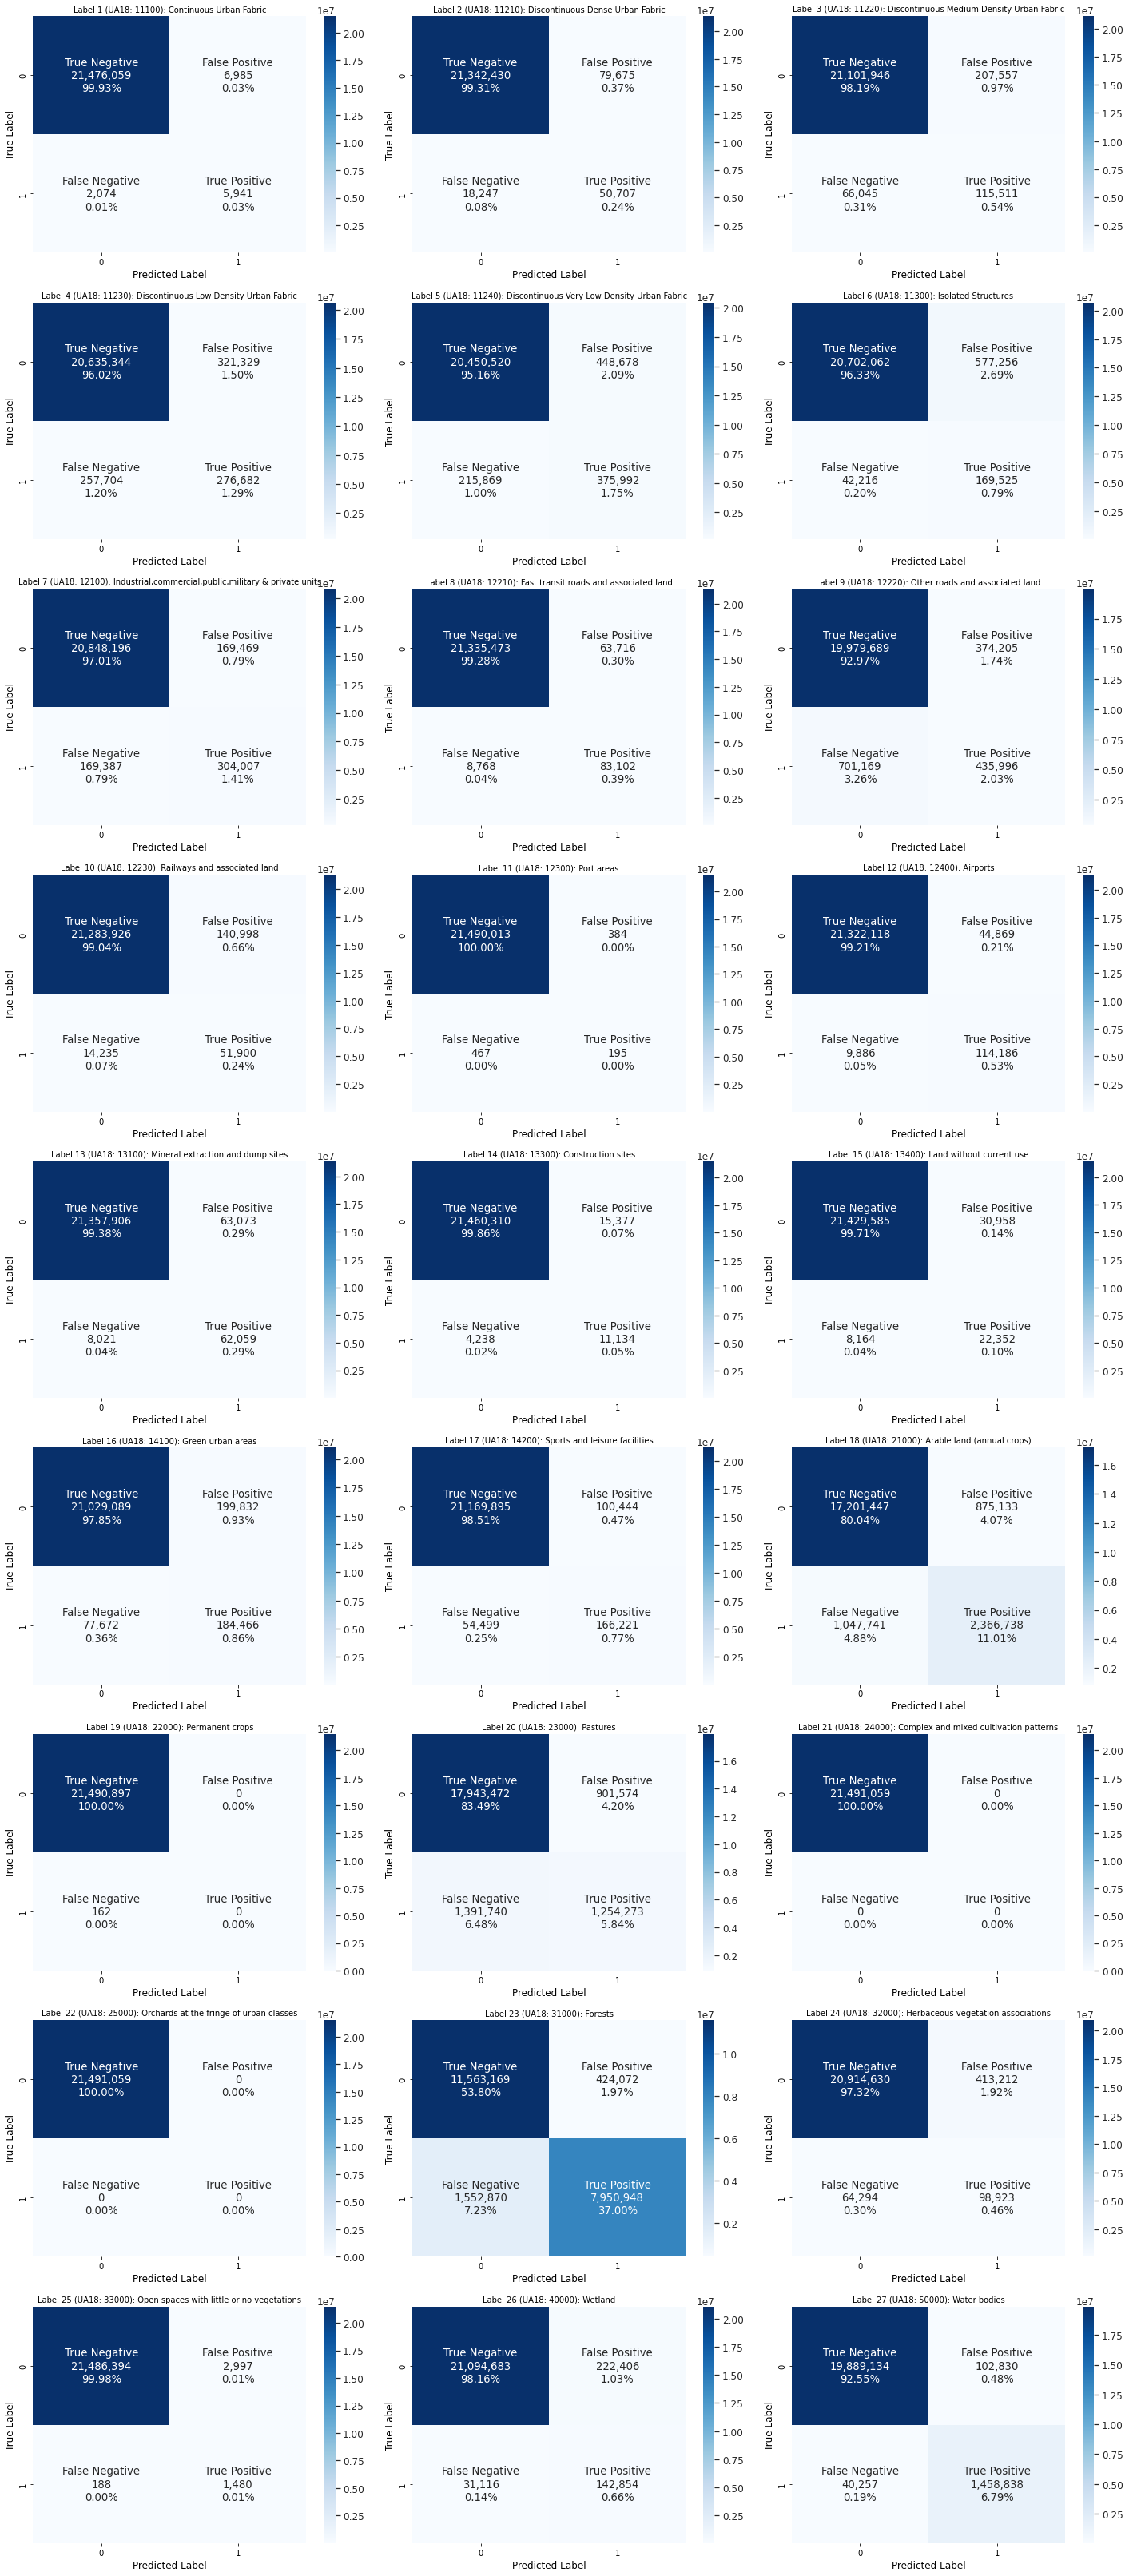

In [14]:
# Plot confusion matrices for late fusion model
plotConfusionMatrices(cMats_lf)